## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# load and read the data file ab_data.csv and display first 5 rows with heads
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# dataframe shape (# of rows, # of columns)
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
# count of unique user id
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# proportion of converted user.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# assing variable for pages that don't line up with its group
not_old = df[df.group != 'treatment'][df.landing_page == 'new_page']
not_new = df[df.landing_page != 'new_page'][df.group == 'treatment']

# calculate all data counts
not_old.count()[0] + not_new.count()[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


3893

f. Do any of the rows have missing values?

In [7]:
# checking any null values at rows
df.isnull().any(axis=1).sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# create df2 copy of df
df2 = df.copy()

# drop rows of not aligned pages with its group 
df2.drop(not_old.index, inplace = True)
df2.drop(not_new.index, inplace = True)
# confirm the shape
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
# check for duplicated user id
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# value_counts user_id and query its frame to check the repeated user_id
df2['user_id'].value_counts().to_frame().query('user_id > 1')

,user_id
773192,2


c. What is the row information for the repeat **user_id**? 

In [12]:
# display all rows information regarding the duplicated user_id 
df2.loc[ df2.user_id.duplicated( keep = False ), : ]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# drop duplicated id 
df2.drop(df2.loc[df2.user_id.duplicated(keep='first'),:].index ,inplace = True)

# confirm we have df2 shape same to df2 unique values
df2.shape[0] == df2.user_id.nunique()

True

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# probabilty of user at control group to be converted
conv_cont = df2[df2['group'] == 'control'].converted.mean()
conv_cont

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# probabilty of user at treatment group to be converted
conv_treat = df2[df2['group'] == 'treatment'].converted.mean()
conv_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
# probabilty of user to receive the new page
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**First impression**

While count treatment group almost same as control group and converstion rate at control group slightly above the rate at treatment group, i can say new_page does not has significant effect on convertion rate and both pages are the same.

<a id='ab_test'></a>
### Part II - A/B Test

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Setting up hypothesis** where assuming that the old page is better unless the new page provide evdince that it is better with type I error 5%.


$$H_{0}: p_{new} <= p_{old} $$
$$H_{1}: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
converted = df2[df2['converted'] == 1]
p_new = converted.count()[0]/ df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = converted.count()[0]/ df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# simulate a new_page_converted [1,0]array for n_new under p_new rate 
new_page_converted = np.random.choice([1,0], size= n_new, p=[p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# simulate a new_page_converted [1,0]array for n_new under p_new rate 
old_page_converted = np.random.choice([1,0], size= n_old, p=[p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# difference of p_new & p_old for the simulated arrays
new_page_converted.mean() - old_page_converted.mean()


0.0010509287082568486

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
# create required list to store differences
p_diffs = []

# tried to use for loop to simulate 10000 differences but its takes more than 
# 15 minutes to show up the results

# using numby random.binomial to simulate both n_new & n_old 10000 times
new_converted_simulation = np.random.binomial(n_new, p_new, size = 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, size = 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

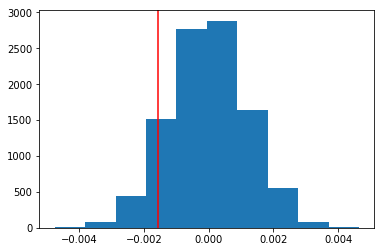

In [26]:
# create observed_diff in actual data between converted users of both group
obsv_diff = conv_treat - conv_cont

plt.hist(p_diffs)
plt.axvline(obsv_diff, color = 'r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# once our simulation looks like normal distribution simulation under the null
# we can calculate p_value 
(p_diffs > obsv_diff).mean()

0.90490000000000004

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

## Conclusions.

- Statisticly We computed values of p_diffs that are greater than observed difference in original data, which called p_value. According to the large p_value (0.9049) we do not have evidence to reject the null, where the new page failed to make significant improvment in converted users that allow us implement it.
- Practicaly, differences of conversion rate between old page and new page were not large enough to give final decsion, we need to check other aspects why we failed to reject the null, we can extend the experiment duration or to send the new page to more users.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted== 1').count()[0]
convert_new = df2.query('group == "treatment" and converted== 1').count()[0]
n_old_count = n_old
n_new_count = n_new

convert_old, convert_new, n_old_count, n_new_count

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
# assing count of converted data, and number of trials in each group
count = [convert_new, convert_old] # converted users
nobs = [n_new_count, n_old_count]  # total trails or observations

# using built in statsmodel function and choose alternative larger as we hope
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'larger')

# check the z_score & p_value
print(z_score, p_value)

# load scipy.stats  
from scipy.stats import norm

# calculate the critical value
norm.ppf(1-(0.05/2))


-1.31092419842 0.905058312759


1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Conclusion.**
- z_score is a statistical test of the z-test, where z-score tells us how many standard deviations we are away from the mean, in our case z_score is -1.
- since z_score below the critical value, we fail to reject the null.
- Results of proportions_ztest is similar to our pervous test, as its p_values are the same (more than 90%).
- Built in statsmodels proportions_ztest is excelent method as computing the p_value and z_score does not take any time, on the other hand bootstraping tooks so much time to get the p_diffs

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Regression method**

I choose logistic regression as we are predicting 2 possible out come (convert or not)

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# add intercept column
df2['intercept'] = 1

# create dummy column for each group but we will use only ab_page
df2[['ab_page', '0_old']] = pd.get_dummies(df2['landing_page'])

# confirm ab_page values
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,0_old
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        21:58:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Summary conclusion**

- p_value in logistic regression is differ than p_value (0.9049) in part II, large p_value in part II means less likely to reject the null but p_value at logistic regression is 0.190 and smaller p-value means more relationship between new page and the conversion rate but due to type I error we could not implement the new page.
- Hypothesis in part II comparing conversion of old page to the conversion of new page, while in part III valuing how much new page affect the total conversion rate .

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Discussion:**
- Practicly since we are analysing e-commerce website, we need to include categorical description regarding our customer then adding it into multiple linear regression may help us targeting the right customers and help us.
- as per below, experiment stayed for 21 days which is not the perfect duration to rely on it.

In [33]:
# convert timestamp column into datetime formate
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
# calculate experiment time
df2.timestamp.max() - df2.timestamp.min()

Timedelta('21 days 23:59:49.081927')

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [34]:
# read countries.csv file
df3 = pd.read_csv('countries.csv')
df3.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [35]:
# join countries column to our dataframe using user_id as index
df2 = df2.join(df3.set_index('user_id'), on='user_id')

df2.head(2) # confirm the joining

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,0_old,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US


In [36]:
# show the countries names
df3.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
# create 3 dummies and will use only 2 
df2[['UK', 'US', 'CA']] = pd.get_dummies(df2['country'])

In [38]:
# fittin a logistic model adding countries
log_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page','UK','US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        21:58:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Discussion:**
- adding countries does not change p_values and still do not have evidence to reject the null regaring the users at different countries.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
# create an interaction between countries and ab_page
df2['UK_ab'] = df2.UK * df2.ab_page
df2['US_ab'] = df2.US * df2.ab_page

In [40]:
# fittin a logistic model adding interactions
log_mod3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page','UK','UK_ab','US','US_ab']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        21:58:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_ab         -0.0469      0.054     -0.872      0.383      -0.152       0.059
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab          0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Discussion - adding interaction**
- adding interaction does not change p_values as well, and we still with no evidence to reject the null.

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0